# Using Quantum Computer as a sound effect processor

based on https://arxiv.org/abs/2301.01595

When producing music, there are different effects that you can do in order to make interesting sounds. This process is often referred to as sound design. This codebook will present how to encode audio in pennylane and how to make your own interesting effects! 

Specifically we'll see how to make a quantum distortion effect that we call the quantum deepfryer.

In [ ]:
from IPython.display import Audio
from IPython.display import Image

display(Audio("Megalovania Meme Sound Effect.wav"))
display(Audio("demo_qhack_1.wav"))
display(Audio("qhack_demo2.wav"))
display(Audio("qhack_demo3.wav"))
display(Audio("qhack_demo4.wav"))
Image(filename='vital_image.jpg')  # For local images

In audio production, there are various effect that you can do in order to make interesting sounds.

in the following screenshot, we can see parameters like distortion (down sampling in this case) and "EQ" (boost or diminishes certain frequencies of a sound)

![Alt text](.\vital_image.jpg)

There are various way and subtleties in doing distortion or any other audio effect for that matter. that's why when producing music you can endup with multiple way of doing the same thing in order to get another "flavor" of the effect. Here's what another plugin that does distortion looks like.

![Alt text](.\fx_image.jpg)

And so, to begin making our own audio effect using a quantum computer, we first import required libraries needed and make function to import .wav audio files

In [151]:
# utility cell
import pennylane as qml
import pennylane.numpy as np
import scipy.io.wavfile
import wave
import time
import math
import matplotlib.pyplot as plt
import copy

# Function to load a WAV file
def load_wav(filename):
    sample_rate, data = scipy.io.wavfile.read(filename)
    # If stereo, convert to mono by averaging the two channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    return sample_rate, data

# Function to save a WAV file
def save_wav(filename, sample_rate, data):
    scipy.io.wavfile.write(filename, sample_rate, data)

In [22]:
filename = 'qhack_demo4.wav'  # audio file to encode into the quantum computer

Then, we encode our audio in a quantum circuit using Quantum Probability Amplitude Modulation (QPAM). The way QPAM encoding works is by taking each individual audio sample in our audio file and making it so that it correspond to a probability amplitude in our encoded quantum circuit. An important thing about QPAM encoding is that it is not lossless. Meaning in its pure theoritical form and in simulator, its still probabilistic.
The details steps on how to encode into QPAM can be seen in the comments of the code below. 
here's an image from the 2301.01595 research paper to clarify. 

![Alt text](qpam.jpg)

In [175]:
sample_rate, original_data = load_wav(filename)

def QPAM_Encoding_Normalization(samples):
    # Normalize the array to be between 0 and 2
    normalized_arr = 2 * (samples - np.min(samples)) / (np.max(samples) - np.min(samples))

    # see 2301.01595 research paper for a deeper explanation on why this works.
    # • Step 1: add 1 to all amplitudes an
    # • Step 2: divide the amplitudes by 2
    # • Step 3: divide again, by the sum of all of the amplitudes
    # • Step 4: take the square root of the result

    np_data = np.array(normalized_arr)
    np_data += 1
    np_data /= 2
    sum = np.sum(np_data)
    np_data = np_data/sum

    print(np_data)
    return np_data

features = QPAM_Encoding_Normalization(original_data)
length = features.shape[0]
nb_qubits = math.ceil(np.log2(length))

[1.13398837e-05 1.13399430e-05 1.13408798e-05 ... 1.31006615e-05
 1.08222664e-05 8.02100313e-06]


C:\Users\Kuift\AppData\Local\Temp\ipykernel_19312\3098465682.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = scipy.io.wavfile.read(filename)


An interesting thing about QPAM is that, to store audio into a quantum circuit, it scale at O(log(n)). meaning, if you have 16 qubits and assuming an audio sampling rate of 44100Hz, you can store 2^16/44100 = 1.48607709751 seconds of audio. with 17 qubits, that would be 2.97215419501 seconds of audio. we can quickly see that it would not take much qubits to store an enormous amount of audio using this method. In this jupyter notebook, we are encoding a sound that last about 2 seconds and therefore, we'll need 17 qubits.

In [207]:
# we are now ready to create our device and display the number of qubits we will endup using.
dev = qml.device('default.qubit', wires=nb_qubits)
nb_qubits

17

We can then use pennylane's very convenient qml.AmplitudeEmbedding to encode the amplitude onto our quantum circuit. Doing so encode our audio in the quantum computing realm. It's at this step that you could add operators like QFT or hadamard or phaseshift to get interesting effect later on. Right now, we are just not putting any gates.

In [188]:
@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)
    # insert your own quantum circuit here to manipulate the audio in a quantum way !
    return qml.probs(wires=range(nb_qubits))
results = circuit(features)
print(f"encoding result: {results}")


encoding result: [1.08557612e-05 1.08558747e-05 1.08576685e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


As you can see, encoding audio using QPAM is pretty straightforward. There are other method but QPAM is simple enough to kinda work on a quantum computer since the circuit depth isn't as deep as other methods. [didn't have time to test on an actual quantum computer, we trust the paper's author for this]. And now, lets retrieve the audio from the circuit and create a wav file. We simply need to measures the probabilities of the circuit to get back our audio. Then, all we need to do is convert it into a standardized audio format : .wav format

In [203]:
# Create a WAV file
normalized_results = ((results - np.min(results)) / (np.max(results) - np.min(results))) * (32767 + 32768) - 32768
newwave_name = f'qhack_demo_{time.time()}.wav'
quantum_samples_array = []
with wave.open(newwave_name, 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    quantum_samples_array = np.array(normalized_results, dtype=np.int16)
    print(quantum_samples_array)
    wav_file.writeframes(np.array(quantum_samples_array).tobytes())
# following is to make certain operation in the jupyter codebook less cumbersome
print(f"{newwave_name} file has been created.")
orig_result = copy.deepcopy(normalized_results)
copy_result = copy.deepcopy(normalized_results)
display(Audio(newwave_name))

[ -4965  -4965  -4961 ... -32768 -32768 -32768]
qhack_demo_1707504695.8699522.wav file has been created.


Lets see the frequency spectrum and the waveform of the decoded sound !

44100


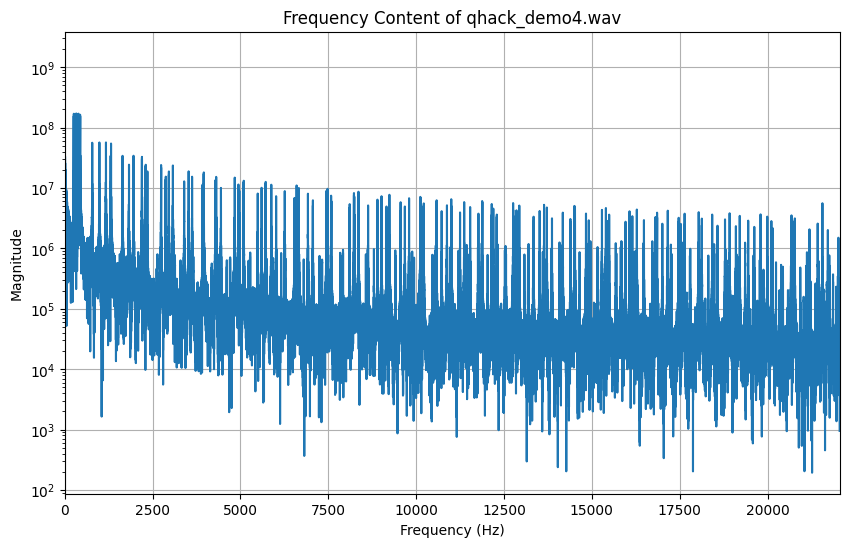

In [204]:
sample_rate, data = scipy.io.wavfile.read(newwave_name)
print(sample_rate)
# If stereo, convert to mono by averaging the two channels
if len(data.shape) == 2:
    data = data.mean(axis=1)

# Perform the Fourier Transform to get frequency content
# Use np.fft.rfft to handle real inputs and improve efficiency
freq_data = np.fft.rfft(data)

# Get the power spectrum (magnitude of the Fourier coefficients)
power_spectrum = np.abs(freq_data)

# Generate frequency axis (only for positive frequencies)
freqs = np.fft.rfftfreq(len(data), d=1/sample_rate)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(freqs, power_spectrum)
plt.title(f'Frequency Content of {filename}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.xlim(0, sample_rate / 2)  # Nyquist limit
plt.grid(True)
plt.show()

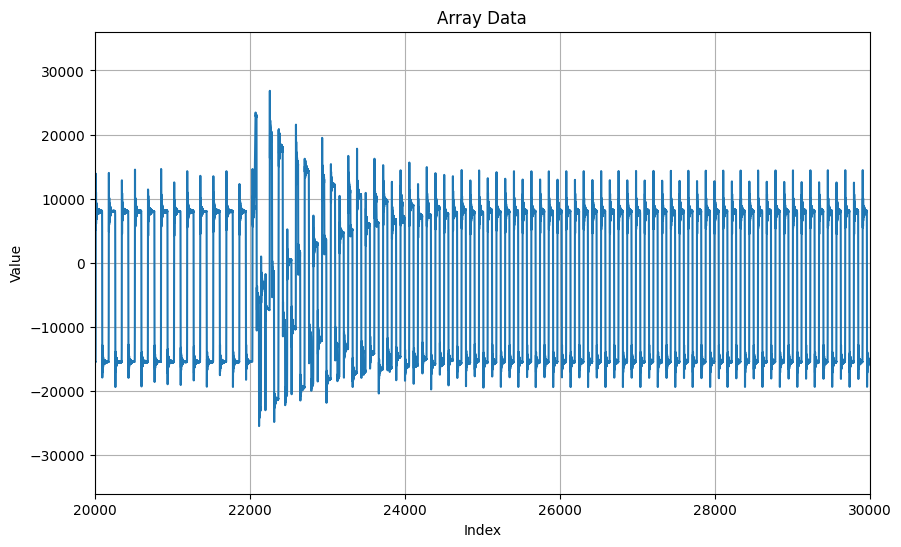

In [190]:
#graphing
plt.figure(figsize=(10, 6))
plt.plot(orig_result)
plt.xlim(20000, 30000)
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Lets see what happen if you "deepfry" it. That is, since QPAM is probabilistic in nature, we want to see how it might sounds after going through the encoding and decoding phase multiple times. lets test the audio "degradation" after going through the quantum audio encoding and decoding process a couple of time to hear the fidelity.

In [199]:
copy_result = copy.deepcopy(orig_result) 
deepfry_quantum_samples_array = copy.deepcopy(quantum_samples_array)
for i in range(2): #CHANGE THE VALUE INSIDE THE RANGE HERE TO DEEPFRY IT EVEN DEEPER
    deepfry_result = circuit(QPAM_Encoding_Normalization(deepfry_quantum_samples_array))
    # Create a WAV file
    copy_result = ((deepfry_result - np.min(deepfry_result)) / (np.max(deepfry_result) - np.min(deepfry_result))) * (32767 + 32768) - 32768
    deepfry_quantum_samples_array = np.array(copy_result, dtype=np.int16)

newwave_name = f'qhack_demo_{time.time()}.wav'
with wave.open(newwave_name, 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    deepfry_quantum_samples_array = np.array(copy_result, dtype=np.int16)
    print(deepfry_quantum_samples_array)
    wav_file.writeframes(np.array(deepfry_quantum_samples_array).tobytes())

display(Audio(newwave_name))

[6.84274073e-06 6.84274073e-06 6.84372521e-06 ... 8.06472464e-06
 8.06472464e-06 8.06472464e-06]
[1.10847992e-05 1.10847992e-05 1.10864102e-05 ... 5.65603114e-06
 5.65603114e-06 5.65603114e-06]
[ 29858  29858  29879 ... -22524 -22524 -22524]


Finally lets compare the deepfried version vs the original one. First, the frequency spectrum.

44100


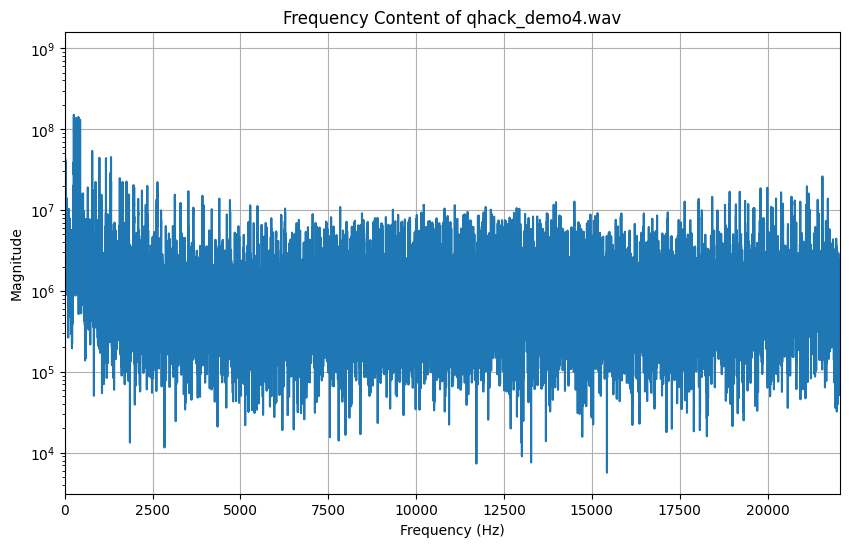

In [202]:
sample_rate, data = scipy.io.wavfile.read(newwave_name)
print(sample_rate)
# If stereo, convert to mono by averaging the two channels
if len(data.shape) == 2:
    data = data.mean(axis=1)

# Perform the Fourier Transform to get frequency content
# Use np.fft.rfft to handle real inputs and improve efficiency
freq_data = np.fft.rfft(data)

# Get the power spectrum (magnitude of the Fourier coefficients)
power_spectrum = np.abs(freq_data)

# Generate frequency axis (only for positive frequencies)
freqs = np.fft.rfftfreq(len(data), d=1/sample_rate)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(freqs, power_spectrum)
plt.title(f'Frequency Content of {filename}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.xlim(0, sample_rate / 2)  # Nyquist limit
plt.grid(True)
plt.show()

Looking at the right part of this frequency spectrum, we can see that some high frequencies got boosted ! and near the 20000, we can see that additionals frequencies were created. This confirm that we made a distortion effect using quantum circuits.
The following is the comparaison between the original waveforme (in orange) and the quantum deefried waveform (in blue)

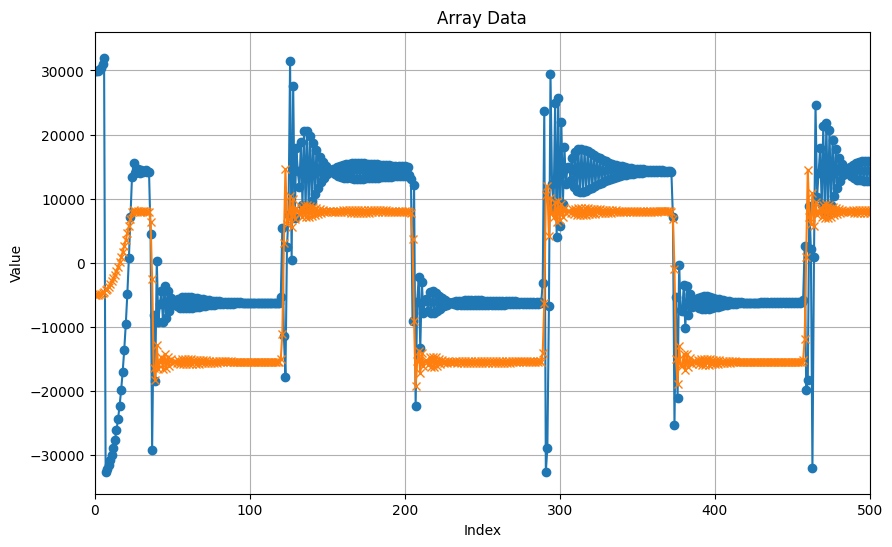

In [197]:
#graphing
plt.figure(figsize=(10, 6))
plt.plot(copy_result, marker='o')
plt.plot(orig_result, marker='x', label='Original Results')
plt.xlim(0, 500)
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()